In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
!pip install tensorflow

In [3]:
!pip install keras

## MNIST Dataset

이번 과제는 [MNIST 필기체 데이터셋](http://yann.lecun.com/exdb/mnist/)을 활용하여 필기체 이미지를 인식하는 이미지 인식 알고리즘을 **Multi Layer Perceptron**로 작성합니다. 복습 차원에서 퍼셉트론 또는 Single Layer Neural Network을 이용해 MNIST 문제를 해결한 다음, Multi Layer Perceptron으로 이것을 개선해보겠습니다.

**1. MNIST 데이터셋 구성**
> 가로 28px, 세로 28px의 필기체 이미지가 주어지며, 필기체는 숫자 0부터 9까지 총 10개의 Label로 구성되어 있습니다. 이미지는 컬러가 없는 흑백 데이터이며, 한 픽셀의 값은 0 ~ 255입니다. (0일수록 어둡고, 255일수록 밝습니다.)

**2. Train, Test Set**
> 데이터는 60,000개의 Train 데이터와 10,000개의 Test 데이터가 주어지는데, Train 데이터로 Multi-layer Neural Network를 학습한 뒤 Test 데이터로 정확도(accuracy)를 측정합니다. 각 변수의 세부 정보는 다음과 같습니다.

   * **X_train**: **Train 데이터의 Feature**입니다. 가로 28px, 세로 28px, 총 60,000개의 데이터로 구성되어 있습니다. 픽셀 하나의 값은 0 ~ 255입니다.
   * **y_train**: **Train 데이터의 Label**입니다. 총 60,000개이며, 이미지가 어떤 숫자를 나타내는지가 적혀 있습니다. 값은 0부터 9까지 입니다.  
   * **X_test**: **Test 데이터의 Feature**입니다. 가로 28px, 세로 28px, 총 10,000개의 데이터로 구성되어 있습니다. 픽셀 하나의 값은 0 ~ 255입니다.
   * **y_test**: **Test 데이터의 Label** 입니다. 총 10,000 개이며, 이미지가 어떤 숫자를 나타내는지가 적혀 있습니다. 값은 0부터 9까지입니다.


**3. 주의 사항**

  * 이전에 ***XOR data를 풀었던 코드를 조금만 응용***하면 매우 쉽게 MNIST 데이터셋 문제를 풀 수 있습니다.
  * Accuracy가 잘 올라가지 않고 그 이유를 잘 모르겠다면, ***Loss Function(=Cross Entropy)를 병행***해서 사용해보세요. 앞서 언급드린대로 Loss Function은 <U>학습이 잘 될수록 0에 수렴하고, 학습이 잘 되지 않을수록 무한대로 발산합니다.</U> 즉, Loss Function을 사용할 결과가 무한대로 발산하고 있다면 무언가 제대로 풀리지 않고 있다는 것입니다.
  * Loss가 제대로 떨어지지 않는다면 문제는 크게 두 가지입니다. 1) weight의 초기값이 좋지 않거나, 2) learning rate가 너무 높거나 낮아서 생기는 문제입니다. Loss가 떨어지지 않는다면 ***weight의 초기값과 learning rate를 바꿔보세요.***

In [6]:
from keras.datasets import mnist

((X_train, y_train), (X_test, y_test)) = mnist.load_data()

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


[5 0 4 1 9 2 1 3 1 4]


<Figure size 432x288 with 0 Axes>

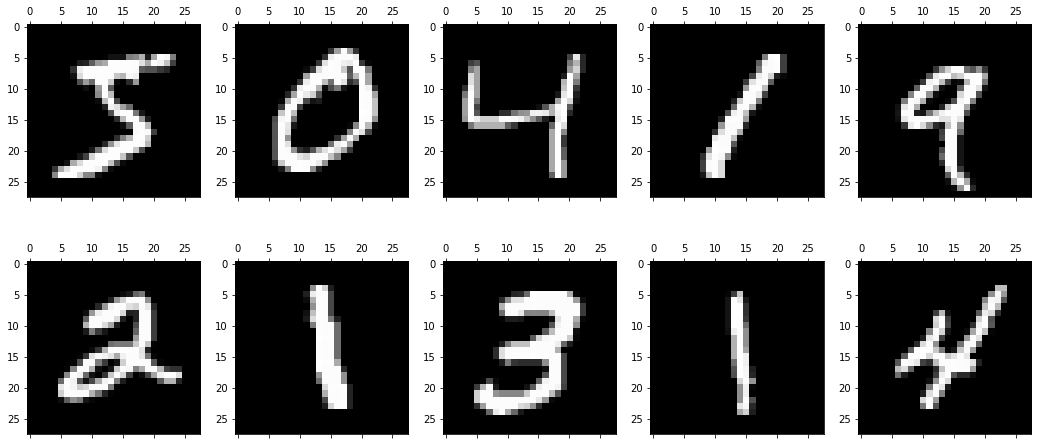

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.gray() 
figures, axes = plt.subplots(nrows=2, ncols=5)
figures.set_size_inches(18, 8)

print(y_train[0:10])

axes[0][0].matshow(X_train[0])
axes[0][1].matshow(X_train[1])
axes[0][2].matshow(X_train[2])
axes[0][3].matshow(X_train[3])
axes[0][4].matshow(X_train[4])
axes[1][0].matshow(X_train[5])
axes[1][1].matshow(X_train[6])
axes[1][2].matshow(X_train[7])
axes[1][3].matshow(X_train[8])
axes[1][4].matshow(X_train[9])

## Preprocessing

In [8]:
X_train = X_train.reshape(60000, 28 * 28)

X_test = X_test.reshape(10000, 28 * 28)

print(X_train.shape, X_test.shape)

(60000, 784) (10000, 784)


In [9]:
from keras.utils import to_categorical

y_train_hot = to_categorical(y_train) 
y_test_hot = to_categorical(y_test)

print(y_train_hot.shape)
print(y_test_hot.shape)

(60000, 10)
(10000, 10)


In [10]:
X_train = X_train.T
y_train_hot = y_train_hot.T
print(X_train.shape, y_train_hot.shape)

X_test = X_test.T
y_test_hot = y_test_hot.T
print(X_test.shape, y_test_hot.shape)

(784, 60000) (10, 60000)
(784, 10000) (10, 10000)


### Define Sigmoid

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

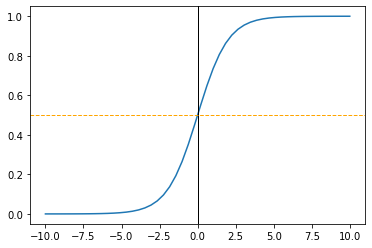

In [12]:
xx = np.linspace(-10, 10) # start=-10, stop=10
yy = sigmoid(xx)
plt.plot(xx, yy)

# -1과 1사이의 값을 갖고, y절편은 0.5입니다.
plt.axvline(x=0, color="black", linewidth=1) 
plt.axhline(y=0.5, linestyle='--', color="orange", linewidth=1)
plt.show()

### Define Cross Entropy

In [13]:
def cross_entropy(actual, predict, eps=1e-15):
    
    actual = np.array(actual)
    predict = np.array(predict)
    
    clipped_predict = np.minimum(np.maximum(predict, eps), 1 - eps)
    
    loss = actual * np.log(clipped_predict) + (1 - actual) * np.log(1 - clipped_predict)
    
    return -1.0 * loss.mean()

## Solving MNIST problem using Single-layer Neural Network

In [14]:
num_epoch = 100
learning_rate = 1.0

w = np.random.uniform(low=-1.0, high=1.0, size=(10, 784))  # (num_labels, num_nodes)
b = np.random.uniform(low=-1.0, high=1.0, size=(10, 1)) # (num_labels, 1)

num_data = X_train.shape[1]

# 학습 시작!
for epoch in range(num_epoch):
    # 먼저 합성곱을 해준 다음, 시그모이드 함수에 넣어줍니다.
    y_predict_hot = np.dot(w, X_train) + b
    y_predict_hot = sigmoid(y_predict_hot)
    
    # 가장 큰 확률값을 갖는 라벨을 예측값으로 만들어줍니다.
    y_predict = np.argmax(y_predict_hot, axis=0)
    accuracy = (y_predict == y_train).mean()   
    
    # 정확도가 0.8에 도달할 때까지 학습합니다.
    if accuracy > 0.8:
        break

    # loss 함수는 cross entropy를 사용하였습니다.
    # 위와 달리 one hot encoding된 y_train_hot을 사용합니다.
    loss = cross_entropy(y_train_hot, y_predict_hot)

    # 일정 시간이 지나면 학습의 경과를 출력합니다.
    if epoch % 10 == 0:
        print("{0:2} accuracy = {1:.5f}, loss = {2:.5f}".format(epoch, accuracy, loss))

    # 경사하강법에 따라 비용함수를 최소화하도록 각 값들을 갱신해줍니다   
    w = w - learning_rate * np.dot((y_predict_hot - y_train_hot), X_train.T) / num_data
    b = b - learning_rate * (y_predict_hot - y_train_hot).mean(axis=1, keepdims=True) # 행 연산

print("----" * 10)
print("{0:2} accuracy = {1:.5f}, loss = {2:.5f}".format(epoch, accuracy, loss))

 0 accuracy = 0.06590, loss = 22.90990
10 accuracy = 0.65895, loss = 1.80087
20 accuracy = 0.65328, loss = 1.46731
30 accuracy = 0.72923, loss = 1.57154
40 accuracy = 0.77702, loss = 1.34522
----------------------------------------
47 accuracy = 0.80603, loss = 1.26688


### Evaluate (Train)

In [15]:
# 학습한 w, b를 가지고 실제값과 예측값을 계산해봅시다.
# 먼저 train set에 대해서 결괏값을 만들어줍니다.
y_predict_hot = np.dot(w, X_train) + b
y_predict_hot = sigmoid(y_predict_hot)
y_predict = np.argmax(y_predict_hot, axis=0)

# actual vs. predict
train_result = pd.DataFrame({'actual': y_train, 'predict': y_predict})

# accuracy는 다음과 같이 계산됩니다.
train_accuracy = (train_result["actual"] == train_result["predict"]).mean(axis=0)
print("Accuracy(train) = {0:.5f}".format(train_accuracy))

print(train_result.shape)
train_result.head(10)

Accuracy(train) = 0.80603
(60000, 2)


,actual,predict
0,5,0
1,0,0
2,4,4
3,1,1
4,9,4
5,2,2
6,1,1
7,3,3
8,1,1
9,4,4


### Evaluate (Test)

In [16]:
# 다음으로 test set에 대해서 결괏값을 만들어줍니다.
y_predict_hot = np.dot(w, X_test) + b
y_predict_hot = sigmoid(y_predict_hot)
y_predict = np.argmax(y_predict_hot, axis=0)

# actual vs. predict
test_result = pd.DataFrame({'actual': y_test, 'predict': y_predict})

# accuracy는 다음과 같이 계산됩니다.
test_accuracy = (test_result["actual"] == test_result["predict"]).mean(axis=0)

print("Accuracy(test) = {0:.5f}".format(test_accuracy))

print(test_result.shape)
test_result.head(10)

Accuracy(test) = 0.81340
(10000, 2)


,actual,predict
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
5,1,1
6,4,4
7,9,9
8,5,0
9,9,9


## Solving MNIST problem using Multi-layer Neural Network

다음으로 Multi Layer Perceptron 알고리즘을 사용할 것입니다. 1개의 은닉층(hidden layer), 특히 노드를 1,000개로 설정함으로써 wide한 인공신경망을 만들어주었습니다. 은닉층이 1개이므로 w와 b를 두 쌍 학습해야 합니다. 이번에는 정확도가 0.9에 도달할 때까지 학습하도록 하겠습니다.

In [17]:
# derivative of sigmoid function
def dsigmoid(A):
    dA = A * (1 - A)
    return dA

In [18]:
num_epoch = 100
learning_rate = 1.4

num_data = X_train.shape[1]

w1 = np.random.uniform(low = -1.0, high = +1.0, size = (1000, 784))
b1 = np.random.uniform(low = -1.0, high = +1.0, size = (1000, 1))
w2 = np.random.uniform(low = -1.0, high = +1.0, size = (10, 1000))
b2 = np.random.uniform(low = -1.0, high = +1.0, size = (10, 1))

for epoch in range(num_epoch):
    z1 = np.dot(w1, X_train) + b1
    a1 = sigmoid(z1)

    z2 = np.dot(w2, a1) + b2
    a2 = sigmoid(z2)

    y_predict_hot = a2

    y_predict = np.argmax(y_predict_hot, axis = 0)
    accuracy = (y_predict == y_train).mean()

    loss = cross_entropy(y_train_hot, y_predict_hot)

    if epoch % 10 == 0:
        print(f"epoch: {epoch:3}, accuracy: {accuracy:.2f}, loss: {loss:.6f}")
    
    if accuracy >= 0.9:
        break
        
    d2 = a2 - y_train_hot
    d1 = np.dot(w2.T, d2) * dsigmoid(a1)
    w2 = w2 - learning_rate * np.dot(d2, a1.T) / num_data
    w1 = w1 - learning_rate * np.dot(d1, X_train.T) / num_data

    b2 = b2 - learning_rate * d2.mean(axis = 1, keepdims = True)
    b1 = b1 - learning_rate * d1.mean(axis = 1, keepdims = True)

print("-----"*10)
print(f"epoch: {epoch:3}, accuracy: {accuracy:.2f}, loss: {loss:.6f}")

epoch:   0, accuracy: 0.10, loss: 5.060319
epoch:  10, accuracy: 0.63, loss: 0.811590
epoch:  20, accuracy: 0.82, loss: 0.240211
epoch:  30, accuracy: 0.85, loss: 0.182537
epoch:  40, accuracy: 0.87, loss: 0.150145
epoch:  50, accuracy: 0.88, loss: 0.131439
epoch:  60, accuracy: 0.90, loss: 0.115745
--------------------------------------------------
epoch:  64, accuracy: 0.90, loss: 0.110989


### Evaluate (Train)

In [19]:
z1 = np.dot(w1, X_train) + b1
a1 = sigmoid(z1)
z2 = np.dot(w2, a1) + b2
a2 = sigmoid(z2)

y_predict_hot = a2
y_predict = np.argmax(y_predict_hot, axis=0)

# actual vs. predict
train_result = pd.DataFrame({'actual': y_train, 'predict': y_predict})

train_accuracy = (train_result["actual"] == train_result["predict"]).mean()
print("Accuracy(train) = {0:.5f}".format(train_accuracy))

print(train_result.shape)
train_result.head(10)

Accuracy(train) = 0.90027
(60000, 2)


,actual,predict
0,5,5
1,0,0
2,4,4
3,1,1
4,9,9
5,2,2
6,1,1
7,3,3
8,1,1
9,4,4


### Evaluate (Test)

In [20]:
z1 = np.dot(w1, X_test) + b1
a1 = sigmoid(z1)
z2 = np.dot(w2, a1) + b2
a2 = sigmoid(z2)

y_predict_hot = a2
y_predict = np.argmax(y_predict_hot, axis=0)

# actual vs. predict
test_result = pd.DataFrame({'actual': y_test, 'predict': y_predict})

test_accuracy = (test_result["actual"] == test_result["predict"]).mean()
print("Accuracy(test) = {0:.5f}".format(test_accuracy))

print(test_result.shape)
test_result.head(10)

Accuracy(test) = 0.87900
(10000, 2)


,actual,predict
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
5,1,1
6,4,4
7,9,9
8,5,6
9,9,9
